# Sequential Q-learning

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import gym
import numpy as np

In [2]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

>**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [3]:
import gym

# Create the Cart-Pole game environment
#env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [4]:
env.reset()
for _ in range(10):
    # env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

state, action, reward, done, info: [ 0.03367204 -0.18377751 -0.02637949  0.27589704] 0 1.0 False {}
state, action, reward, done, info: [ 0.02999649  0.01171068 -0.02086155 -0.02498789] 1 1.0 False {}
state, action, reward, done, info: [ 0.0302307   0.20712549 -0.0213613  -0.32417918] 1 1.0 False {}
state, action, reward, done, info: [ 0.03437321  0.01231411 -0.02784489 -0.03830853] 0 1.0 False {}
state, action, reward, done, info: [ 0.03461949  0.20782406 -0.02861106 -0.33964511] 1 1.0 False {}
state, action, reward, done, info: [ 0.03877597  0.40334119 -0.03540396 -0.64121127] 1 1.0 False {}
state, action, reward, done, info: [ 0.0468428   0.59893833 -0.04822819 -0.94482972] 1 1.0 False {}
state, action, reward, done, info: [ 0.05882157  0.7946756  -0.06712478 -1.25226782] 1 1.0 False {}
state, action, reward, done, info: [ 0.07471508  0.99059021 -0.09217014 -1.56519781] 1 1.0 False {}
state, action, reward, done, info: [ 0.09452688  1.18668501 -0.12347409 -1.88515114] 1 1.0 False {}


To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [5]:
# print(rewards[-20:])
# print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
# print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
# print(np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
# print(np.max(np.array(rewards)), np.min(np.array(rewards)))
# print(np.max(np.array(states)), np.min(np.array(states)))

The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [132]:
def model_input(state_size, lstm_size, batch_size=1):
    actions = tf.placeholder(tf.int32, [None], name='actions')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
        
    gru = tf.nn.rnn_cell.GRUCell(lstm_size)
    cell = tf.nn.rnn_cell.MultiRNNCell([gru], state_is_tuple=False)
    initial_state = cell.zero_state(batch_size, tf.float32)
    
    return actions, states, targetQs, cell, initial_state

In [133]:
# RNN generator or sequence generator
def generator(states, initial_state, cell, lstm_size, num_classes, reuse=False): 
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        inputs = tf.layers.dense(inputs=states, units=lstm_size)
        print(states.shape, inputs.shape)
        
        # with tf.variable_scope('dynamic_rnn_', reuse=tf.AUTO_REUSE):
        # dynamic means adapt to the batch_size
        inputs_rnn = tf.reshape(inputs, [1, -1, lstm_size]) # NxH -> 1xNxH
        print(inputs_rnn.shape, initial_state.shape)
        outputs_rnn, final_state = tf.nn.dynamic_rnn(cell=cell, inputs=inputs_rnn, initial_state=initial_state)
        print(outputs_rnn.shape, final_state.shape)
        outputs = tf.reshape(outputs_rnn, [-1, lstm_size]) # 1xNxH -> NxH
        print(outputs.shape)

        # Last fully connected layer
        logits = tf.layers.dense(inputs=outputs, units=num_classes)
        print(logits.shape)
        #predictions = tf.nn.softmax(logits)
        
        # logits are the action logits
        return logits, final_state

In [134]:
def model_outputs(action_size, hidden_size, states, cell, initial_state):
    actions_logits, final_state = generator(states=states, cell=cell, initial_state=initial_state, 
                                            lstm_size=hidden_size, num_classes=action_size)
    return actions_logits, final_state

In [142]:
def model_loss(action_size, hidden_size, states, cell, initial_state, actions, targetQs):
    actions_logits, _ = generator(states=states, cell=cell, initial_state=initial_state, 
                                  lstm_size=hidden_size, num_classes=action_size, reuse=True)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    Qs = tf.reduce_max(actions_logits*actions_labels, axis=1)
    loss = tf.reduce_mean(tf.square(Qs - targetQs))
#     loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs_logits, 
#                                                                   labels=tf.nn.sigmoid(targetQs[1:])))
    return actions_logits, loss

In [143]:
def model_opt(loss, learning_rate):
    """
    Get optimization operations in order
    :param loss: Generator loss Tensor for action prediction
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # # Optimize
    # with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
    # #opt = tf.train.AdamOptimizer(learning_rate).minimize(loss, var_list=g_vars)

    #grads, _ = tf.clip_by_global_norm(t_list=tf.gradients(loss, g_vars), clip_norm=5) # usually around 1-5
    grads = tf.gradients(loss, g_vars)
    opt = tf.train.AdamOptimizer(learning_rate).apply_gradients(grads_and_vars=zip(grads, g_vars))

    return opt

In [144]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.actions, self.states, self.targetQs, cell, self.initial_state = model_input(
            state_size=state_size, lstm_size=hidden_size)
        
        # Output of the Model: calculating the loss and forwad pass
        self.actions_logits, self.final_state = model_outputs(
            action_size=action_size, hidden_size=hidden_size, 
            states=self.states, cell=cell, initial_state=self.initial_state)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.loss = model_loss(
            action_size=action_size, hidden_size=hidden_size, 
            states=self.states, actions=self.actions, targetQs=self.targetQs, 
            cell=cell, initial_state=self.initial_state)

        # Update the model: backward pass and backprop
        self.opt = model_opt(loss=self.loss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [145]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
        self.states = deque(maxlen=max_size)

In [157]:
# episode_total_reward = deque(maxlen=10)

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [158]:
# print('state:', np.array(states).shape[1], 
#       'action size: {}'.format((np.max(np.array(actions)) - np.min(np.array(actions)))+1))

In [166]:
# Training parameters
batch_size = 32                # number of samples in the memory/ experience as mini-batch size
learning_rate = 0.001          # learning rate for adam

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4                 # number of units for the input state/observation -- simulation
hidden_size = 64               # number of units in each Q-network hidden layer -- simulation
action_size = 2                # number of units for the output actions -- simulation

In [167]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

# Init the memory
memory = Memory(max_size=batch_size)

(?, 4) (?, 64)
(1, ?, 64) (1, 64)
(1, ?, 64) (1, 64)
(?, 64)
(?, 2)
(?, 4) (?, 64)
(1, ?, 64) (1, 64)
(1, ?, 64) (1, 64)
(?, 64)
(?, 2)


## Populate the memory (exprience memory)

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [168]:
state = env.reset()
for _ in range(batch_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    memory.buffer.append([state, action, next_state, reward, float(done)])
    state = next_state
    if done is True:
        state = env.reset()

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [169]:
memory.buffer[0]

[array([ 0.03912216,  0.01218385, -0.00347782,  0.04461972]),
 1,
 array([ 0.03936583,  0.2073555 , -0.00258543, -0.24915846]),
 1.0,
 0.0]

In [170]:
# states, rewards, actions

In [ ]:
# Now train with experiences
saver = tf.train.Saver() # save the trained model
rewards_list, loss_list = [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    initial_state = sess.run(model.initial_state) # Qs or current batch or states[:-1]
    total_step = 0 # Explore or exploit parameter
    episode_loss = deque(maxlen=batch_size)
    episode_reward = deque(maxlen=batch_size)
    
    # Training episodes/epochs
    for ep in range(11111):
        total_reward = 0
        loss_batch = []
        state = env.reset()

        # Training steps/batches
        while True:
            action_logits, final_state = sess.run([model.actions_logits, model.final_state],
                                                  feed_dict = {model.states: state.reshape([1, -1]), 
                                                               model.initial_state: initial_state})
            
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done)])
            memory.states.append([initial_state, final_state])
            total_reward += reward
            initial_state = final_state
            state = next_state

            # Training
            batch = memory.buffer
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            next_states = np.array([each[2] for each in batch])
            rewards = np.array([each[3] for each in batch])
            dones = np.array([each[4] for each in batch])
            rnn_states = memory.states
            initial_states = np.array([each[0] for each in rnn_states])
            final_states = np.array([each[1] for each in rnn_states])
            actions_logits = sess.run(model.actions_logits, 
                                      feed_dict = {model.states: next_states, 
                                                   model.initial_state: final_states[0].reshape([1, -1])})
            nextQs = np.max(actions_logits, axis=1) * (1-dones)
            targetQs = rewards + (0.99 * nextQs)
            loss, _ = sess.run([model.loss, model.opt], 
                               feed_dict = {model.states: states, 
                                            model.actions: actions,
                                            model.targetQs: targetQs,
                                            model.initial_state: initial_states[0].reshape([1, -1])})
            loss_batch.append(loss)
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode: {}'.format(ep),
              'meanReward: {:.4f}'.format(np.mean(episode_reward)),
              'meanLoss: {:.4f}'.format(np.mean(loss_batch)),
              'ExploreP: {:.4f}'.format(explore_p))
        rewards_list.append([ep, np.mean(episode_reward)])
        loss_list.append([ep, np.mean(loss_batch)])
        if(np.mean(episode_reward) >= 500):
            break
    
    saver.save(sess, 'checkpoints/model.ckpt')

Episode: 0 meanReward: 13.0000 meanLoss: 1.4376 ExploreP: 0.9987
Episode: 1 meanReward: 13.0000 meanLoss: 2.0859 ExploreP: 0.9974
Episode: 2 meanReward: 12.3333 meanLoss: 1.8955 ExploreP: 0.9963
Episode: 3 meanReward: 13.7500 meanLoss: 7.2121 ExploreP: 0.9946
Episode: 4 meanReward: 15.6000 meanLoss: 10.4739 ExploreP: 0.9923
Episode: 5 meanReward: 16.6667 meanLoss: 7.0556 ExploreP: 0.9901
Episode: 6 meanReward: 22.1429 meanLoss: 2.2025 ExploreP: 0.9848
Episode: 7 meanReward: 26.7500 meanLoss: 4.1586 ExploreP: 0.9790
Episode: 8 meanReward: 25.3333 meanLoss: 9.7931 ExploreP: 0.9777
Episode: 9 meanReward: 24.7000 meanLoss: 17.9609 ExploreP: 0.9758
Episode: 10 meanReward: 25.0000 meanLoss: 15.0360 ExploreP: 0.9731
Episode: 11 meanReward: 24.5000 meanLoss: 16.6036 ExploreP: 0.9713
Episode: 12 meanReward: 24.3077 meanLoss: 19.1308 ExploreP: 0.9692
Episode: 13 meanReward: 25.9286 meanLoss: 13.1408 ExploreP: 0.9647
Episode: 14 meanReward: 25.3333 meanLoss: 17.2051 ExploreP: 0.9631
Episode: 15 m

Episode: 123 meanReward: 27.9375 meanLoss: 1.6444 ExploreP: 0.7266
Episode: 124 meanReward: 31.0000 meanLoss: 1.0872 ExploreP: 0.7186
Episode: 125 meanReward: 32.0312 meanLoss: 29.3952 ExploreP: 0.7149
Episode: 126 meanReward: 32.3438 meanLoss: 41.7736 ExploreP: 0.7125
Episode: 127 meanReward: 31.8438 meanLoss: 8.8394 ExploreP: 0.7108
Episode: 128 meanReward: 32.2500 meanLoss: 49.0338 ExploreP: 0.7091
Episode: 129 meanReward: 34.8125 meanLoss: 22.9686 ExploreP: 0.7026
Episode: 130 meanReward: 34.8750 meanLoss: 17.2163 ExploreP: 0.7011
Episode: 131 meanReward: 34.8750 meanLoss: 34.7936 ExploreP: 0.7001
Episode: 132 meanReward: 34.7812 meanLoss: 8.3001 ExploreP: 0.6992
Episode: 133 meanReward: 34.9688 meanLoss: 9.1053 ExploreP: 0.6979
Episode: 134 meanReward: 35.6562 meanLoss: 55.0049 ExploreP: 0.6953
Episode: 135 meanReward: 35.1250 meanLoss: 11.4377 ExploreP: 0.6942
Episode: 136 meanReward: 34.1562 meanLoss: 8.8163 ExploreP: 0.6930
Episode: 137 meanReward: 34.5312 meanLoss: 12.8247 Exp

Episode: 244 meanReward: 53.8438 meanLoss: 95.8031 ExploreP: 0.4702
Episode: 245 meanReward: 54.6250 meanLoss: 17.1217 ExploreP: 0.4682
Episode: 246 meanReward: 54.7500 meanLoss: 99.3669 ExploreP: 0.4670
Episode: 247 meanReward: 56.8438 meanLoss: 32.1049 ExploreP: 0.4630
Episode: 248 meanReward: 57.6562 meanLoss: 10.5373 ExploreP: 0.4611
Episode: 249 meanReward: 57.9062 meanLoss: 21.3735 ExploreP: 0.4598
Episode: 250 meanReward: 58.2500 meanLoss: 112.7230 ExploreP: 0.4586
Episode: 251 meanReward: 59.5938 meanLoss: 39.6320 ExploreP: 0.4558
Episode: 252 meanReward: 63.4062 meanLoss: 645.6880 ExploreP: 0.4498
Episode: 253 meanReward: 66.0312 meanLoss: 1016.1744 ExploreP: 0.4453
Episode: 254 meanReward: 69.3750 meanLoss: 125.1309 ExploreP: 0.4397
Episode: 255 meanReward: 76.4062 meanLoss: 848.2800 ExploreP: 0.4291
Episode: 256 meanReward: 79.2188 meanLoss: 506.2054 ExploreP: 0.4244
Episode: 257 meanReward: 79.2188 meanLoss: 109.9089 ExploreP: 0.4190
Episode: 258 meanReward: 79.0625 meanLos

Episode: 364 meanReward: 36.6562 meanLoss: 50.9958 ExploreP: 0.1423
Episode: 365 meanReward: 23.9062 meanLoss: 30.4880 ExploreP: 0.1411
Episode: 366 meanReward: 23.9375 meanLoss: 47.5651 ExploreP: 0.1410
Episode: 367 meanReward: 23.7812 meanLoss: 80.0348 ExploreP: 0.1409
Episode: 368 meanReward: 23.8438 meanLoss: 79.0256 ExploreP: 0.1407
Episode: 369 meanReward: 23.8750 meanLoss: 173.2134 ExploreP: 0.1406
Episode: 370 meanReward: 28.7812 meanLoss: 24.6810 ExploreP: 0.1384
Episode: 371 meanReward: 32.5312 meanLoss: 36.1436 ExploreP: 0.1368
Episode: 372 meanReward: 33.1250 meanLoss: 183.8340 ExploreP: 0.1364
Episode: 373 meanReward: 36.0938 meanLoss: 47.9671 ExploreP: 0.1350
Episode: 374 meanReward: 36.9062 meanLoss: 28.8908 ExploreP: 0.1325
Episode: 375 meanReward: 40.6562 meanLoss: 19.5001 ExploreP: 0.1307
Episode: 376 meanReward: 42.0938 meanLoss: 40.7214 ExploreP: 0.1299
Episode: 377 meanReward: 42.4062 meanLoss: 165.8188 ExploreP: 0.1295
Episode: 378 meanReward: 45.0312 meanLoss: 34

Episode: 484 meanReward: 122.6875 meanLoss: 11.9570 ExploreP: 0.0338
Episode: 485 meanReward: 123.0000 meanLoss: 206.1926 ExploreP: 0.0338
Episode: 486 meanReward: 122.7500 meanLoss: 325.6977 ExploreP: 0.0337
Episode: 487 meanReward: 122.3750 meanLoss: 151.1148 ExploreP: 0.0337
Episode: 488 meanReward: 107.0625 meanLoss: 99.9217 ExploreP: 0.0337
Episode: 489 meanReward: 106.5625 meanLoss: 21.5002 ExploreP: 0.0332
Episode: 490 meanReward: 92.5000 meanLoss: 89.5140 ExploreP: 0.0332
Episode: 491 meanReward: 100.8438 meanLoss: 5.2977 ExploreP: 0.0320
Episode: 492 meanReward: 116.0938 meanLoss: 15.7279 ExploreP: 0.0310
Episode: 493 meanReward: 120.3438 meanLoss: 51.5393 ExploreP: 0.0306
Episode: 494 meanReward: 120.5312 meanLoss: 113.8769 ExploreP: 0.0306
Episode: 495 meanReward: 120.9062 meanLoss: 159.2715 ExploreP: 0.0306
Episode: 496 meanReward: 136.2188 meanLoss: 7.7270 ExploreP: 0.0296
Episode: 497 meanReward: 150.0938 meanLoss: 14.8125 ExploreP: 0.0286
Episode: 498 meanReward: 148.843

Episode: 603 meanReward: 17.2500 meanLoss: 30.0164 ExploreP: 0.0148
Episode: 604 meanReward: 16.5625 meanLoss: 23.5237 ExploreP: 0.0148
Episode: 605 meanReward: 16.0938 meanLoss: 19.3239 ExploreP: 0.0148
Episode: 606 meanReward: 15.5625 meanLoss: 18.6169 ExploreP: 0.0148
Episode: 607 meanReward: 15.2500 meanLoss: 17.9241 ExploreP: 0.0148
Episode: 608 meanReward: 15.0938 meanLoss: 15.8434 ExploreP: 0.0148
Episode: 609 meanReward: 14.4688 meanLoss: 18.0989 ExploreP: 0.0148
Episode: 610 meanReward: 14.2500 meanLoss: 19.4276 ExploreP: 0.0148
Episode: 611 meanReward: 14.4062 meanLoss: 13.8388 ExploreP: 0.0147
Episode: 612 meanReward: 14.3438 meanLoss: 11.1489 ExploreP: 0.0147
Episode: 613 meanReward: 14.3750 meanLoss: 11.4575 ExploreP: 0.0147
Episode: 614 meanReward: 14.5625 meanLoss: 14.5796 ExploreP: 0.0147
Episode: 615 meanReward: 14.7812 meanLoss: 10.6013 ExploreP: 0.0147
Episode: 616 meanReward: 14.6250 meanLoss: 9.3077 ExploreP: 0.0147
Episode: 617 meanReward: 14.4375 meanLoss: 11.567

Episode: 724 meanReward: 159.2812 meanLoss: 35.6712 ExploreP: 0.0112
Episode: 725 meanReward: 168.0625 meanLoss: 3.9992 ExploreP: 0.0111
Episode: 726 meanReward: 165.7188 meanLoss: 40.8168 ExploreP: 0.0111
Episode: 727 meanReward: 177.0312 meanLoss: 4.1344 ExploreP: 0.0110
Episode: 728 meanReward: 177.4375 meanLoss: 27.5279 ExploreP: 0.0110
Episode: 729 meanReward: 173.1875 meanLoss: 24.2169 ExploreP: 0.0110
Episode: 730 meanReward: 159.5625 meanLoss: 122.0836 ExploreP: 0.0110
Episode: 731 meanReward: 163.0938 meanLoss: 5.3577 ExploreP: 0.0110
Episode: 732 meanReward: 163.2812 meanLoss: 3.5981 ExploreP: 0.0110
Episode: 733 meanReward: 172.0000 meanLoss: 11.7272 ExploreP: 0.0109
Episode: 734 meanReward: 169.4375 meanLoss: 142.3718 ExploreP: 0.0109
Episode: 735 meanReward: 168.7812 meanLoss: 20.8057 ExploreP: 0.0109
Episode: 736 meanReward: 178.1562 meanLoss: 14.5222 ExploreP: 0.0109
Episode: 737 meanReward: 187.2188 meanLoss: 8.1737 ExploreP: 0.0108
Episode: 738 meanReward: 197.9375 mea

Episode: 844 meanReward: 353.7188 meanLoss: 227.4338 ExploreP: 0.0101
Episode: 845 meanReward: 338.7812 meanLoss: 163.6609 ExploreP: 0.0101
Episode: 846 meanReward: 323.5625 meanLoss: 61.6105 ExploreP: 0.0101
Episode: 847 meanReward: 316.1562 meanLoss: 9.2434 ExploreP: 0.0101
Episode: 848 meanReward: 301.7500 meanLoss: 62.1893 ExploreP: 0.0101
Episode: 849 meanReward: 287.8125 meanLoss: 60.1945 ExploreP: 0.0101
Episode: 850 meanReward: 272.5625 meanLoss: 39.6456 ExploreP: 0.0101
Episode: 851 meanReward: 263.4375 meanLoss: 114.0973 ExploreP: 0.0101
Episode: 852 meanReward: 275.1250 meanLoss: 29.8148 ExploreP: 0.0101
Episode: 853 meanReward: 269.7812 meanLoss: 9.4025 ExploreP: 0.0101
Episode: 854 meanReward: 269.7812 meanLoss: 11.5534 ExploreP: 0.0101
Episode: 855 meanReward: 269.9375 meanLoss: 76.8310 ExploreP: 0.0101
Episode: 856 meanReward: 283.6562 meanLoss: 10.6357 ExploreP: 0.0101
Episode: 857 meanReward: 283.6562 meanLoss: 14.4524 ExploreP: 0.0100
Episode: 858 meanReward: 283.6562

Episode: 963 meanReward: 201.9688 meanLoss: 24.0389 ExploreP: 0.0100
Episode: 964 meanReward: 186.7188 meanLoss: 125.4110 ExploreP: 0.0100
Episode: 965 meanReward: 178.5938 meanLoss: 229.4328 ExploreP: 0.0100
Episode: 966 meanReward: 178.5938 meanLoss: 7.3901 ExploreP: 0.0100
Episode: 967 meanReward: 169.9062 meanLoss: 68.1943 ExploreP: 0.0100
Episode: 968 meanReward: 182.5312 meanLoss: 8.5173 ExploreP: 0.0100
Episode: 969 meanReward: 197.8438 meanLoss: 15.7230 ExploreP: 0.0100
Episode: 970 meanReward: 213.1875 meanLoss: 17.4049 ExploreP: 0.0100
Episode: 971 meanReward: 213.6875 meanLoss: 117.5848 ExploreP: 0.0100
Episode: 972 meanReward: 216.9062 meanLoss: 10.9713 ExploreP: 0.0100
Episode: 973 meanReward: 219.5000 meanLoss: 32.4277 ExploreP: 0.0100
Episode: 974 meanReward: 218.3438 meanLoss: 28.6306 ExploreP: 0.0100
Episode: 975 meanReward: 233.6875 meanLoss: 5.5088 ExploreP: 0.0100
Episode: 976 meanReward: 222.4688 meanLoss: 61.2974 ExploreP: 0.0100
Episode: 977 meanReward: 214.3438 

Episode: 1082 meanReward: 268.2812 meanLoss: 21.0165 ExploreP: 0.0100
Episode: 1083 meanReward: 283.0000 meanLoss: 18.2902 ExploreP: 0.0100
Episode: 1084 meanReward: 278.1250 meanLoss: 315.8046 ExploreP: 0.0100
Episode: 1085 meanReward: 277.9062 meanLoss: 109.9193 ExploreP: 0.0100
Episode: 1086 meanReward: 263.7188 meanLoss: 53.6638 ExploreP: 0.0100
Episode: 1087 meanReward: 258.0938 meanLoss: 25.2244 ExploreP: 0.0100
Episode: 1088 meanReward: 248.2812 meanLoss: 72.3869 ExploreP: 0.0100
Episode: 1089 meanReward: 240.3438 meanLoss: 68.6193 ExploreP: 0.0100
Episode: 1090 meanReward: 232.0625 meanLoss: 78.1667 ExploreP: 0.0100
Episode: 1091 meanReward: 216.8750 meanLoss: 121.9456 ExploreP: 0.0100
Episode: 1092 meanReward: 201.6562 meanLoss: 172.3047 ExploreP: 0.0100
Episode: 1093 meanReward: 186.4688 meanLoss: 387.8358 ExploreP: 0.0100
Episode: 1094 meanReward: 184.3125 meanLoss: 357.7788 ExploreP: 0.0100
Episode: 1095 meanReward: 197.6562 meanLoss: 188.6943 ExploreP: 0.0100
Episode: 1096

Episode: 1199 meanReward: 11.6875 meanLoss: 1373.0615 ExploreP: 0.0100
Episode: 1200 meanReward: 11.5938 meanLoss: 1441.4829 ExploreP: 0.0100
Episode: 1201 meanReward: 11.5000 meanLoss: 1424.3253 ExploreP: 0.0100
Episode: 1202 meanReward: 11.5312 meanLoss: 1294.6718 ExploreP: 0.0100
Episode: 1203 meanReward: 11.5312 meanLoss: 1244.9908 ExploreP: 0.0100
Episode: 1204 meanReward: 11.7188 meanLoss: 1295.8115 ExploreP: 0.0100
Episode: 1205 meanReward: 11.7500 meanLoss: 1396.5040 ExploreP: 0.0100
Episode: 1206 meanReward: 12.0000 meanLoss: 1426.7815 ExploreP: 0.0100
Episode: 1207 meanReward: 12.0000 meanLoss: 1417.8030 ExploreP: 0.0100
Episode: 1208 meanReward: 12.0000 meanLoss: 1415.4043 ExploreP: 0.0100
Episode: 1209 meanReward: 12.0312 meanLoss: 1349.3226 ExploreP: 0.0100
Episode: 1210 meanReward: 12.1250 meanLoss: 1231.1039 ExploreP: 0.0100
Episode: 1211 meanReward: 12.2188 meanLoss: 1261.9930 ExploreP: 0.0100
Episode: 1212 meanReward: 12.1562 meanLoss: 1305.8358 ExploreP: 0.0100
Episod

Episode: 1316 meanReward: 18.4688 meanLoss: 1414.5619 ExploreP: 0.0100
Episode: 1317 meanReward: 19.0312 meanLoss: 1158.5752 ExploreP: 0.0100
Episode: 1318 meanReward: 19.0625 meanLoss: 1273.4039 ExploreP: 0.0100
Episode: 1319 meanReward: 19.7188 meanLoss: 1625.8556 ExploreP: 0.0100
Episode: 1320 meanReward: 19.2500 meanLoss: 1798.0106 ExploreP: 0.0100
Episode: 1321 meanReward: 19.6250 meanLoss: 1783.9332 ExploreP: 0.0100
Episode: 1322 meanReward: 19.6875 meanLoss: 1709.0333 ExploreP: 0.0100
Episode: 1323 meanReward: 19.8125 meanLoss: 1627.2782 ExploreP: 0.0100
Episode: 1324 meanReward: 19.4062 meanLoss: 1528.9203 ExploreP: 0.0100
Episode: 1325 meanReward: 19.3750 meanLoss: 1531.4694 ExploreP: 0.0100
Episode: 1326 meanReward: 19.4688 meanLoss: 1558.2727 ExploreP: 0.0100
Episode: 1327 meanReward: 19.4375 meanLoss: 1595.5139 ExploreP: 0.0100
Episode: 1328 meanReward: 19.4375 meanLoss: 1583.9819 ExploreP: 0.0100
Episode: 1329 meanReward: 19.5625 meanLoss: 1558.6836 ExploreP: 0.0100
Episod

Episode: 1432 meanReward: 15.6250 meanLoss: 1589.6500 ExploreP: 0.0100
Episode: 1433 meanReward: 15.6250 meanLoss: 1617.3407 ExploreP: 0.0100
Episode: 1434 meanReward: 15.5938 meanLoss: 1571.8234 ExploreP: 0.0100
Episode: 1435 meanReward: 15.6562 meanLoss: 1522.3735 ExploreP: 0.0100
Episode: 1436 meanReward: 15.3750 meanLoss: 1570.9624 ExploreP: 0.0100
Episode: 1437 meanReward: 15.7188 meanLoss: 1651.5162 ExploreP: 0.0100
Episode: 1438 meanReward: 15.7188 meanLoss: 1681.0151 ExploreP: 0.0100
Episode: 1439 meanReward: 16.0312 meanLoss: 1670.6521 ExploreP: 0.0100
Episode: 1440 meanReward: 16.0938 meanLoss: 1649.2904 ExploreP: 0.0100
Episode: 1441 meanReward: 16.1250 meanLoss: 1655.9103 ExploreP: 0.0100
Episode: 1442 meanReward: 16.1250 meanLoss: 1618.6710 ExploreP: 0.0100
Episode: 1443 meanReward: 15.8750 meanLoss: 1629.5145 ExploreP: 0.0100
Episode: 1444 meanReward: 15.8750 meanLoss: 1657.7939 ExploreP: 0.0100
Episode: 1445 meanReward: 15.7500 meanLoss: 1637.0913 ExploreP: 0.0100
Episod

Episode: 1548 meanReward: 20.2812 meanLoss: 1530.9675 ExploreP: 0.0100
Episode: 1549 meanReward: 20.2500 meanLoss: 1506.9194 ExploreP: 0.0100
Episode: 1550 meanReward: 20.1562 meanLoss: 1514.3591 ExploreP: 0.0100
Episode: 1551 meanReward: 20.2500 meanLoss: 1561.5809 ExploreP: 0.0100
Episode: 1552 meanReward: 16.5625 meanLoss: 1598.9478 ExploreP: 0.0100
Episode: 1553 meanReward: 16.5312 meanLoss: 1571.4062 ExploreP: 0.0100
Episode: 1554 meanReward: 16.0938 meanLoss: 1560.5992 ExploreP: 0.0100
Episode: 1555 meanReward: 19.6250 meanLoss: 1548.6707 ExploreP: 0.0100
Episode: 1556 meanReward: 19.7188 meanLoss: 1171.9604 ExploreP: 0.0100
Episode: 1557 meanReward: 19.7500 meanLoss: 1095.6414 ExploreP: 0.0100
Episode: 1558 meanReward: 19.8125 meanLoss: 1099.1731 ExploreP: 0.0100
Episode: 1559 meanReward: 19.8125 meanLoss: 1178.3605 ExploreP: 0.0100
Episode: 1560 meanReward: 20.1250 meanLoss: 1477.4564 ExploreP: 0.0100
Episode: 1561 meanReward: 20.1250 meanLoss: 1686.3735 ExploreP: 0.0100
Episod

Episode: 1664 meanReward: 15.4375 meanLoss: 1191.5509 ExploreP: 0.0100
Episode: 1665 meanReward: 15.3438 meanLoss: 1292.6180 ExploreP: 0.0100
Episode: 1666 meanReward: 15.2812 meanLoss: 1337.7003 ExploreP: 0.0100
Episode: 1667 meanReward: 15.3125 meanLoss: 1395.1232 ExploreP: 0.0100
Episode: 1668 meanReward: 15.2188 meanLoss: 1428.4729 ExploreP: 0.0100
Episode: 1669 meanReward: 15.2188 meanLoss: 1456.3661 ExploreP: 0.0100
Episode: 1670 meanReward: 15.2188 meanLoss: 1444.2546 ExploreP: 0.0100
Episode: 1671 meanReward: 15.5312 meanLoss: 1637.2761 ExploreP: 0.0100
Episode: 1672 meanReward: 15.5312 meanLoss: 1722.2590 ExploreP: 0.0100
Episode: 1673 meanReward: 15.1250 meanLoss: 1645.7754 ExploreP: 0.0100
Episode: 1674 meanReward: 15.1250 meanLoss: 1580.8979 ExploreP: 0.0100
Episode: 1675 meanReward: 15.1250 meanLoss: 1540.5278 ExploreP: 0.0100
Episode: 1676 meanReward: 15.1250 meanLoss: 1562.5570 ExploreP: 0.0100
Episode: 1677 meanReward: 15.0938 meanLoss: 1550.6793 ExploreP: 0.0100
Episod

Episode: 1780 meanReward: 22.8125 meanLoss: 1132.0326 ExploreP: 0.0100
Episode: 1781 meanReward: 22.4062 meanLoss: 1213.9180 ExploreP: 0.0100
Episode: 1782 meanReward: 22.4062 meanLoss: 1227.5903 ExploreP: 0.0100
Episode: 1783 meanReward: 22.7812 meanLoss: 1436.3276 ExploreP: 0.0100
Episode: 1784 meanReward: 22.8438 meanLoss: 1615.2269 ExploreP: 0.0100
Episode: 1785 meanReward: 22.7812 meanLoss: 1618.0854 ExploreP: 0.0100
Episode: 1786 meanReward: 22.8438 meanLoss: 1581.0598 ExploreP: 0.0100
Episode: 1787 meanReward: 22.7812 meanLoss: 1509.7922 ExploreP: 0.0100
Episode: 1788 meanReward: 23.2812 meanLoss: 1615.7567 ExploreP: 0.0100
Episode: 1789 meanReward: 23.3438 meanLoss: 1721.3308 ExploreP: 0.0100
Episode: 1790 meanReward: 23.3438 meanLoss: 1680.8949 ExploreP: 0.0100
Episode: 1791 meanReward: 23.2812 meanLoss: 1611.6373 ExploreP: 0.0100
Episode: 1792 meanReward: 23.3438 meanLoss: 1593.2537 ExploreP: 0.0100
Episode: 1793 meanReward: 23.1250 meanLoss: 1617.4984 ExploreP: 0.0100
Episod

Episode: 1896 meanReward: 24.4375 meanLoss: 1610.8381 ExploreP: 0.0100
Episode: 1897 meanReward: 24.3750 meanLoss: 1669.8090 ExploreP: 0.0100
Episode: 1898 meanReward: 24.3750 meanLoss: 1608.8123 ExploreP: 0.0100
Episode: 1899 meanReward: 24.4062 meanLoss: 1546.2886 ExploreP: 0.0100
Episode: 1900 meanReward: 24.4062 meanLoss: 1589.0454 ExploreP: 0.0100
Episode: 1901 meanReward: 24.5625 meanLoss: 1603.2389 ExploreP: 0.0100
Episode: 1902 meanReward: 21.9688 meanLoss: 1225.3722 ExploreP: 0.0100
Episode: 1903 meanReward: 21.9688 meanLoss: 1430.0188 ExploreP: 0.0100
Episode: 1904 meanReward: 21.9062 meanLoss: 1480.1696 ExploreP: 0.0100
Episode: 1905 meanReward: 21.9375 meanLoss: 1480.9393 ExploreP: 0.0100
Episode: 1906 meanReward: 22.0625 meanLoss: 1519.8302 ExploreP: 0.0100
Episode: 1907 meanReward: 22.0938 meanLoss: 1513.0466 ExploreP: 0.0100
Episode: 1908 meanReward: 21.5000 meanLoss: 1520.5745 ExploreP: 0.0100
Episode: 1909 meanReward: 21.5312 meanLoss: 1543.6055 ExploreP: 0.0100
Episod

Episode: 2012 meanReward: 20.4375 meanLoss: 1165.4919 ExploreP: 0.0100
Episode: 2013 meanReward: 20.4688 meanLoss: 1178.1505 ExploreP: 0.0100
Episode: 2014 meanReward: 20.7188 meanLoss: 1386.4596 ExploreP: 0.0100
Episode: 2015 meanReward: 20.6562 meanLoss: 1535.8273 ExploreP: 0.0100
Episode: 2016 meanReward: 20.5938 meanLoss: 1547.4390 ExploreP: 0.0100
Episode: 2017 meanReward: 20.6562 meanLoss: 1514.6906 ExploreP: 0.0100
Episode: 2018 meanReward: 21.0938 meanLoss: 1663.1055 ExploreP: 0.0100
Episode: 2019 meanReward: 21.0625 meanLoss: 1755.8544 ExploreP: 0.0100
Episode: 2020 meanReward: 21.6875 meanLoss: 1814.7811 ExploreP: 0.0100
Episode: 2021 meanReward: 17.7812 meanLoss: 1836.3763 ExploreP: 0.0100
Episode: 2022 meanReward: 16.6875 meanLoss: 1757.5541 ExploreP: 0.0100
Episode: 2023 meanReward: 16.6562 meanLoss: 1688.9630 ExploreP: 0.0100
Episode: 2024 meanReward: 16.6250 meanLoss: 1648.9681 ExploreP: 0.0100
Episode: 2025 meanReward: 16.6562 meanLoss: 1634.3851 ExploreP: 0.0100
Episod

Episode: 2128 meanReward: 18.0625 meanLoss: 1411.3907 ExploreP: 0.0100
Episode: 2129 meanReward: 18.3125 meanLoss: 1522.7601 ExploreP: 0.0100
Episode: 2130 meanReward: 18.3438 meanLoss: 1537.3875 ExploreP: 0.0100
Episode: 2131 meanReward: 18.3125 meanLoss: 1634.9150 ExploreP: 0.0100
Episode: 2132 meanReward: 18.3125 meanLoss: 1602.5465 ExploreP: 0.0100
Episode: 2133 meanReward: 14.5312 meanLoss: 1562.6067 ExploreP: 0.0100
Episode: 2134 meanReward: 14.3750 meanLoss: 1547.3713 ExploreP: 0.0100
Episode: 2135 meanReward: 14.4062 meanLoss: 1499.0496 ExploreP: 0.0100
Episode: 2136 meanReward: 14.6250 meanLoss: 1665.2731 ExploreP: 0.0100
Episode: 2137 meanReward: 14.6562 meanLoss: 1646.4963 ExploreP: 0.0100
Episode: 2138 meanReward: 15.6875 meanLoss: 1946.7981 ExploreP: 0.0100
Episode: 2139 meanReward: 15.6875 meanLoss: 2045.6471 ExploreP: 0.0100
Episode: 2140 meanReward: 15.6875 meanLoss: 1870.7786 ExploreP: 0.0100
Episode: 2141 meanReward: 15.7188 meanLoss: 1700.7672 ExploreP: 0.0100
Episod

Episode: 2245 meanReward: 19.3438 meanLoss: 1580.1271 ExploreP: 0.0100
Episode: 2246 meanReward: 19.2812 meanLoss: 1638.8457 ExploreP: 0.0100
Episode: 2247 meanReward: 19.1250 meanLoss: 1645.0562 ExploreP: 0.0100
Episode: 2248 meanReward: 19.5625 meanLoss: 1724.4010 ExploreP: 0.0100
Episode: 2249 meanReward: 19.5625 meanLoss: 1800.8881 ExploreP: 0.0100
Episode: 2250 meanReward: 19.5625 meanLoss: 1814.5531 ExploreP: 0.0100
Episode: 2251 meanReward: 19.4688 meanLoss: 1726.8320 ExploreP: 0.0100
Episode: 2252 meanReward: 19.4688 meanLoss: 1673.9397 ExploreP: 0.0100
Episode: 2253 meanReward: 19.4688 meanLoss: 1649.1477 ExploreP: 0.0100
Episode: 2254 meanReward: 15.5938 meanLoss: 1613.2148 ExploreP: 0.0100
Episode: 2255 meanReward: 12.0000 meanLoss: 1615.7122 ExploreP: 0.0100
Episode: 2256 meanReward: 12.0000 meanLoss: 1675.4115 ExploreP: 0.0100
Episode: 2257 meanReward: 11.9375 meanLoss: 1668.2532 ExploreP: 0.0100
Episode: 2258 meanReward: 11.9688 meanLoss: 1584.3844 ExploreP: 0.0100
Episod

Episode: 2362 meanReward: 10.8438 meanLoss: 1552.3308 ExploreP: 0.0100
Episode: 2363 meanReward: 10.8438 meanLoss: 1586.1375 ExploreP: 0.0100
Episode: 2364 meanReward: 10.7812 meanLoss: 1639.9429 ExploreP: 0.0100
Episode: 2365 meanReward: 10.7500 meanLoss: 1609.0586 ExploreP: 0.0100
Episode: 2366 meanReward: 10.7500 meanLoss: 1577.4312 ExploreP: 0.0100
Episode: 2367 meanReward: 10.8438 meanLoss: 1649.4150 ExploreP: 0.0100
Episode: 2368 meanReward: 10.9062 meanLoss: 1667.8544 ExploreP: 0.0100
Episode: 2369 meanReward: 10.9688 meanLoss: 1685.1573 ExploreP: 0.0100
Episode: 2370 meanReward: 10.9375 meanLoss: 1658.2766 ExploreP: 0.0100
Episode: 2371 meanReward: 10.9062 meanLoss: 1640.3225 ExploreP: 0.0100
Episode: 2372 meanReward: 11.0000 meanLoss: 1690.0944 ExploreP: 0.0100
Episode: 2373 meanReward: 11.0000 meanLoss: 1750.3303 ExploreP: 0.0100
Episode: 2374 meanReward: 11.0625 meanLoss: 1707.9569 ExploreP: 0.0100
Episode: 2375 meanReward: 11.0625 meanLoss: 1604.7960 ExploreP: 0.0100
Episod

Episode: 2478 meanReward: 27.1250 meanLoss: 1469.1880 ExploreP: 0.0100
Episode: 2479 meanReward: 27.1562 meanLoss: 1096.6290 ExploreP: 0.0100
Episode: 2480 meanReward: 27.3438 meanLoss: 1075.4882 ExploreP: 0.0100
Episode: 2481 meanReward: 27.2812 meanLoss: 1151.4546 ExploreP: 0.0100
Episode: 2482 meanReward: 23.3125 meanLoss: 1229.3855 ExploreP: 0.0100
Episode: 2483 meanReward: 19.6875 meanLoss: 1221.6458 ExploreP: 0.0100
Episode: 2484 meanReward: 19.6250 meanLoss: 1296.9242 ExploreP: 0.0100
Episode: 2485 meanReward: 18.8125 meanLoss: 1502.4746 ExploreP: 0.0100
Episode: 2486 meanReward: 18.8125 meanLoss: 1537.4515 ExploreP: 0.0100
Episode: 2487 meanReward: 18.8125 meanLoss: 1575.8357 ExploreP: 0.0100
Episode: 2488 meanReward: 18.7188 meanLoss: 1519.7056 ExploreP: 0.0100
Episode: 2489 meanReward: 18.6875 meanLoss: 1459.6619 ExploreP: 0.0100
Episode: 2490 meanReward: 18.5000 meanLoss: 1426.5922 ExploreP: 0.0100
Episode: 2491 meanReward: 21.9375 meanLoss: 1425.9890 ExploreP: 0.0100
Episod

Episode: 2594 meanReward: 16.0938 meanLoss: 1619.1215 ExploreP: 0.0100
Episode: 2595 meanReward: 16.0312 meanLoss: 1618.3999 ExploreP: 0.0100
Episode: 2596 meanReward: 15.9688 meanLoss: 1633.4269 ExploreP: 0.0100
Episode: 2597 meanReward: 15.9375 meanLoss: 1586.7438 ExploreP: 0.0100
Episode: 2598 meanReward: 15.6875 meanLoss: 1638.6869 ExploreP: 0.0100
Episode: 2599 meanReward: 15.7812 meanLoss: 1649.7848 ExploreP: 0.0100
Episode: 2600 meanReward: 15.8438 meanLoss: 1565.6876 ExploreP: 0.0100
Episode: 2601 meanReward: 16.4062 meanLoss: 1657.7223 ExploreP: 0.0100
Episode: 2602 meanReward: 16.3750 meanLoss: 1785.1047 ExploreP: 0.0100
Episode: 2603 meanReward: 16.4688 meanLoss: 1708.2194 ExploreP: 0.0100
Episode: 2604 meanReward: 16.4688 meanLoss: 1555.2645 ExploreP: 0.0100
Episode: 2605 meanReward: 17.4062 meanLoss: 1652.1604 ExploreP: 0.0100
Episode: 2606 meanReward: 13.9062 meanLoss: 1744.3254 ExploreP: 0.0100
Episode: 2607 meanReward: 13.1562 meanLoss: 1689.3125 ExploreP: 0.0100
Episod

Episode: 2710 meanReward: 18.4375 meanLoss: 1670.1656 ExploreP: 0.0100
Episode: 2711 meanReward: 18.4062 meanLoss: 1616.8362 ExploreP: 0.0100
Episode: 2712 meanReward: 19.2500 meanLoss: 1792.4268 ExploreP: 0.0100
Episode: 2713 meanReward: 19.1875 meanLoss: 1845.3955 ExploreP: 0.0100
Episode: 2714 meanReward: 19.5312 meanLoss: 1796.3228 ExploreP: 0.0100
Episode: 2715 meanReward: 19.5312 meanLoss: 1810.4811 ExploreP: 0.0100
Episode: 2716 meanReward: 19.4688 meanLoss: 1802.8492 ExploreP: 0.0100
Episode: 2717 meanReward: 19.5625 meanLoss: 1766.1543 ExploreP: 0.0100
Episode: 2718 meanReward: 19.6250 meanLoss: 1727.6405 ExploreP: 0.0100
Episode: 2719 meanReward: 19.6250 meanLoss: 1666.9473 ExploreP: 0.0100
Episode: 2720 meanReward: 19.6250 meanLoss: 1617.8899 ExploreP: 0.0100
Episode: 2721 meanReward: 19.6250 meanLoss: 1584.4497 ExploreP: 0.0100
Episode: 2722 meanReward: 19.6250 meanLoss: 1660.7010 ExploreP: 0.0100
Episode: 2723 meanReward: 19.5938 meanLoss: 1686.5453 ExploreP: 0.0100
Episod

Episode: 2826 meanReward: 15.1562 meanLoss: 1642.7883 ExploreP: 0.0100
Episode: 2827 meanReward: 15.2188 meanLoss: 1666.2616 ExploreP: 0.0100
Episode: 2828 meanReward: 15.6250 meanLoss: 1689.8507 ExploreP: 0.0100
Episode: 2829 meanReward: 15.6250 meanLoss: 1686.6158 ExploreP: 0.0100
Episode: 2830 meanReward: 15.5625 meanLoss: 1683.3621 ExploreP: 0.0100
Episode: 2831 meanReward: 15.5938 meanLoss: 1568.1693 ExploreP: 0.0100
Episode: 2832 meanReward: 15.5625 meanLoss: 1546.9768 ExploreP: 0.0100
Episode: 2833 meanReward: 15.5625 meanLoss: 1588.5763 ExploreP: 0.0100
Episode: 2834 meanReward: 11.8750 meanLoss: 1592.7335 ExploreP: 0.0100
Episode: 2835 meanReward: 15.7812 meanLoss: 1631.3296 ExploreP: 0.0100
Episode: 2836 meanReward: 15.8125 meanLoss: 1182.8995 ExploreP: 0.0100
Episode: 2837 meanReward: 15.8438 meanLoss: 1078.2435 ExploreP: 0.0100
Episode: 2838 meanReward: 15.8750 meanLoss: 1091.7872 ExploreP: 0.0100
Episode: 2839 meanReward: 15.8438 meanLoss: 1182.5653 ExploreP: 0.0100
Episod

Episode: 2942 meanReward: 18.8438 meanLoss: 1524.9032 ExploreP: 0.0100
Episode: 2943 meanReward: 19.1875 meanLoss: 1080.2952 ExploreP: 0.0100
Episode: 2944 meanReward: 19.1875 meanLoss: 1073.4694 ExploreP: 0.0100
Episode: 2945 meanReward: 19.1562 meanLoss: 1172.6348 ExploreP: 0.0100
Episode: 2946 meanReward: 19.1250 meanLoss: 1263.3118 ExploreP: 0.0100
Episode: 2947 meanReward: 19.2188 meanLoss: 1320.0277 ExploreP: 0.0100
Episode: 2948 meanReward: 19.1875 meanLoss: 1411.7892 ExploreP: 0.0100
Episode: 2949 meanReward: 19.2500 meanLoss: 1477.0029 ExploreP: 0.0100
Episode: 2950 meanReward: 19.1875 meanLoss: 1510.7734 ExploreP: 0.0100
Episode: 2951 meanReward: 19.1875 meanLoss: 1520.2852 ExploreP: 0.0100
Episode: 2952 meanReward: 19.1875 meanLoss: 1496.2950 ExploreP: 0.0100
Episode: 2953 meanReward: 15.8125 meanLoss: 1675.5219 ExploreP: 0.0100
Episode: 2954 meanReward: 15.0312 meanLoss: 1732.6437 ExploreP: 0.0100
Episode: 2955 meanReward: 15.0312 meanLoss: 1694.7571 ExploreP: 0.0100
Episod

Episode: 3058 meanReward: 15.6250 meanLoss: 1655.0034 ExploreP: 0.0100
Episode: 3059 meanReward: 15.5938 meanLoss: 1638.3534 ExploreP: 0.0100
Episode: 3060 meanReward: 15.9688 meanLoss: 1691.3433 ExploreP: 0.0100
Episode: 3061 meanReward: 12.2812 meanLoss: 1758.0664 ExploreP: 0.0100
Episode: 3062 meanReward: 12.9062 meanLoss: 1866.6896 ExploreP: 0.0100
Episode: 3063 meanReward: 12.6875 meanLoss: 1941.6254 ExploreP: 0.0100
Episode: 3064 meanReward: 12.4688 meanLoss: 1814.0472 ExploreP: 0.0100
Episode: 3065 meanReward: 12.4375 meanLoss: 1694.9498 ExploreP: 0.0100
Episode: 3066 meanReward: 12.4688 meanLoss: 1647.2443 ExploreP: 0.0100
Episode: 3067 meanReward: 12.5312 meanLoss: 1591.6060 ExploreP: 0.0100
Episode: 3068 meanReward: 12.0625 meanLoss: 1586.8856 ExploreP: 0.0100
Episode: 3069 meanReward: 12.1250 meanLoss: 1605.9209 ExploreP: 0.0100
Episode: 3070 meanReward: 12.1562 meanLoss: 1617.9749 ExploreP: 0.0100
Episode: 3071 meanReward: 12.1250 meanLoss: 1614.7180 ExploreP: 0.0100
Episod

Episode: 3174 meanReward: 15.7812 meanLoss: 1794.8579 ExploreP: 0.0100
Episode: 3175 meanReward: 19.2188 meanLoss: 1648.5118 ExploreP: 0.0100
Episode: 3176 meanReward: 19.3125 meanLoss: 1199.7842 ExploreP: 0.0100
Episode: 3177 meanReward: 19.3750 meanLoss: 1131.3394 ExploreP: 0.0100
Episode: 3178 meanReward: 19.3750 meanLoss: 1143.3025 ExploreP: 0.0100
Episode: 3179 meanReward: 19.3750 meanLoss: 1276.1217 ExploreP: 0.0100
Episode: 3180 meanReward: 19.3438 meanLoss: 1400.2290 ExploreP: 0.0100
Episode: 3181 meanReward: 19.3125 meanLoss: 1481.7699 ExploreP: 0.0100
Episode: 3182 meanReward: 15.5312 meanLoss: 1509.8625 ExploreP: 0.0100
Episode: 3183 meanReward: 15.5000 meanLoss: 1542.0042 ExploreP: 0.0100
Episode: 3184 meanReward: 15.1562 meanLoss: 1582.5114 ExploreP: 0.0100
Episode: 3185 meanReward: 15.2188 meanLoss: 1597.3246 ExploreP: 0.0100
Episode: 3186 meanReward: 15.3438 meanLoss: 1660.9442 ExploreP: 0.0100
Episode: 3187 meanReward: 15.2500 meanLoss: 1675.4008 ExploreP: 0.0100
Episod

Episode: 3290 meanReward: 10.9375 meanLoss: 1693.1278 ExploreP: 0.0100
Episode: 3291 meanReward: 10.8750 meanLoss: 1787.1006 ExploreP: 0.0100
Episode: 3292 meanReward: 10.8438 meanLoss: 1672.1259 ExploreP: 0.0100
Episode: 3293 meanReward: 10.8125 meanLoss: 1691.2386 ExploreP: 0.0100
Episode: 3294 meanReward: 10.7812 meanLoss: 1702.9972 ExploreP: 0.0100
Episode: 3295 meanReward: 10.7812 meanLoss: 1683.6946 ExploreP: 0.0100
Episode: 3296 meanReward: 10.8750 meanLoss: 1729.1803 ExploreP: 0.0100
Episode: 3297 meanReward: 10.8438 meanLoss: 1658.9255 ExploreP: 0.0100
Episode: 3298 meanReward: 10.8750 meanLoss: 1675.1274 ExploreP: 0.0100
Episode: 3299 meanReward: 10.9062 meanLoss: 1703.7382 ExploreP: 0.0100
Episode: 3300 meanReward: 10.9062 meanLoss: 1679.6116 ExploreP: 0.0100
Episode: 3301 meanReward: 10.9375 meanLoss: 1706.5540 ExploreP: 0.0100
Episode: 3302 meanReward: 10.9062 meanLoss: 1713.1821 ExploreP: 0.0100
Episode: 3303 meanReward: 10.9688 meanLoss: 1732.7526 ExploreP: 0.0100
Episod

Episode: 3406 meanReward: 15.2500 meanLoss: 1597.9016 ExploreP: 0.0100
Episode: 3407 meanReward: 15.1875 meanLoss: 1604.1702 ExploreP: 0.0100
Episode: 3408 meanReward: 15.8438 meanLoss: 1792.2112 ExploreP: 0.0100
Episode: 3409 meanReward: 15.8125 meanLoss: 1827.5776 ExploreP: 0.0100
Episode: 3410 meanReward: 19.3438 meanLoss: 1601.7080 ExploreP: 0.0100
Episode: 3411 meanReward: 20.1562 meanLoss: 1170.9438 ExploreP: 0.0100
Episode: 3412 meanReward: 20.1250 meanLoss: 1270.0237 ExploreP: 0.0100
Episode: 3413 meanReward: 20.2188 meanLoss: 1405.1082 ExploreP: 0.0100
Episode: 3414 meanReward: 20.2500 meanLoss: 1525.2251 ExploreP: 0.0100
Episode: 3415 meanReward: 20.2500 meanLoss: 1575.4567 ExploreP: 0.0100
Episode: 3416 meanReward: 20.2500 meanLoss: 1612.0867 ExploreP: 0.0100
Episode: 3417 meanReward: 19.6875 meanLoss: 1586.1199 ExploreP: 0.0100
Episode: 3418 meanReward: 19.6875 meanLoss: 1560.1562 ExploreP: 0.0100
Episode: 3419 meanReward: 19.6875 meanLoss: 1562.8231 ExploreP: 0.0100
Episod

Episode: 3522 meanReward: 16.8125 meanLoss: 1701.0093 ExploreP: 0.0100
Episode: 3523 meanReward: 16.7188 meanLoss: 1745.1409 ExploreP: 0.0100
Episode: 3524 meanReward: 16.6875 meanLoss: 1693.5560 ExploreP: 0.0100
Episode: 3525 meanReward: 13.1562 meanLoss: 1606.4991 ExploreP: 0.0100
Episode: 3526 meanReward: 13.0625 meanLoss: 1626.4739 ExploreP: 0.0100
Episode: 3527 meanReward: 13.0625 meanLoss: 1650.7998 ExploreP: 0.0100
Episode: 3528 meanReward: 12.9688 meanLoss: 1576.2305 ExploreP: 0.0100
Episode: 3529 meanReward: 13.0312 meanLoss: 1569.0924 ExploreP: 0.0100
Episode: 3530 meanReward: 13.0312 meanLoss: 1611.9998 ExploreP: 0.0100
Episode: 3531 meanReward: 13.0000 meanLoss: 1626.8075 ExploreP: 0.0100
Episode: 3532 meanReward: 12.9688 meanLoss: 1611.3812 ExploreP: 0.0100
Episode: 3533 meanReward: 12.9375 meanLoss: 1637.9286 ExploreP: 0.0100
Episode: 3534 meanReward: 12.9375 meanLoss: 1644.2753 ExploreP: 0.0100
Episode: 3535 meanReward: 12.5938 meanLoss: 1614.4514 ExploreP: 0.0100
Episod

Episode: 3638 meanReward: 11.3438 meanLoss: 1587.5215 ExploreP: 0.0100
Episode: 3639 meanReward: 11.3438 meanLoss: 1651.5730 ExploreP: 0.0100
Episode: 3640 meanReward: 14.8125 meanLoss: 1581.9128 ExploreP: 0.0100
Episode: 3641 meanReward: 16.6875 meanLoss: 1256.8846 ExploreP: 0.0100
Episode: 3642 meanReward: 20.3750 meanLoss: 1552.3573 ExploreP: 0.0100
Episode: 3643 meanReward: 20.0625 meanLoss: 1356.8965 ExploreP: 0.0100
Episode: 3644 meanReward: 20.0938 meanLoss: 1231.5828 ExploreP: 0.0100
Episode: 3645 meanReward: 20.0625 meanLoss: 1183.2874 ExploreP: 0.0100
Episode: 3646 meanReward: 20.0938 meanLoss: 1185.6215 ExploreP: 0.0100
Episode: 3647 meanReward: 20.0938 meanLoss: 1244.4915 ExploreP: 0.0100
Episode: 3648 meanReward: 20.0938 meanLoss: 1329.9086 ExploreP: 0.0100
Episode: 3649 meanReward: 20.0000 meanLoss: 1365.0963 ExploreP: 0.0100
Episode: 3650 meanReward: 20.0000 meanLoss: 1440.2327 ExploreP: 0.0100
Episode: 3651 meanReward: 19.9688 meanLoss: 1468.6190 ExploreP: 0.0100
Episod

Episode: 3754 meanReward: 11.7812 meanLoss: 1812.6068 ExploreP: 0.0100
Episode: 3755 meanReward: 11.6875 meanLoss: 1728.1661 ExploreP: 0.0100
Episode: 3756 meanReward: 11.6875 meanLoss: 1681.1436 ExploreP: 0.0100
Episode: 3757 meanReward: 11.6562 meanLoss: 1617.7037 ExploreP: 0.0100
Episode: 3758 meanReward: 11.6562 meanLoss: 1597.0730 ExploreP: 0.0100
Episode: 3759 meanReward: 11.6562 meanLoss: 1603.0718 ExploreP: 0.0100
Episode: 3760 meanReward: 12.4062 meanLoss: 1819.6041 ExploreP: 0.0100
Episode: 3761 meanReward: 12.4375 meanLoss: 1896.4272 ExploreP: 0.0100
Episode: 3762 meanReward: 12.4688 meanLoss: 1816.0287 ExploreP: 0.0100
Episode: 3763 meanReward: 12.4688 meanLoss: 1743.2332 ExploreP: 0.0100
Episode: 3764 meanReward: 12.4688 meanLoss: 1632.1605 ExploreP: 0.0100
Episode: 3765 meanReward: 12.0000 meanLoss: 1676.6179 ExploreP: 0.0100
Episode: 3766 meanReward: 12.0312 meanLoss: 1670.3232 ExploreP: 0.0100
Episode: 3767 meanReward: 12.0000 meanLoss: 1660.3428 ExploreP: 0.0100
Episod

Episode: 3870 meanReward: 15.6250 meanLoss: 1271.2668 ExploreP: 0.0100
Episode: 3871 meanReward: 15.7500 meanLoss: 1075.6245 ExploreP: 0.0100
Episode: 3872 meanReward: 15.7188 meanLoss: 1017.0728 ExploreP: 0.0100
Episode: 3873 meanReward: 16.0938 meanLoss: 1165.9275 ExploreP: 0.0100
Episode: 3874 meanReward: 16.1250 meanLoss: 1248.9067 ExploreP: 0.0100
Episode: 3875 meanReward: 16.0938 meanLoss: 1265.0077 ExploreP: 0.0100
Episode: 3876 meanReward: 16.1562 meanLoss: 1247.6133 ExploreP: 0.0100
Episode: 3877 meanReward: 15.9062 meanLoss: 1306.1630 ExploreP: 0.0100
Episode: 3878 meanReward: 15.9688 meanLoss: 1364.6296 ExploreP: 0.0100
Episode: 3879 meanReward: 15.5625 meanLoss: 1335.2491 ExploreP: 0.0100
Episode: 3880 meanReward: 15.5312 meanLoss: 1328.4587 ExploreP: 0.0100
Episode: 3881 meanReward: 15.1250 meanLoss: 1342.9755 ExploreP: 0.0100
Episode: 3882 meanReward: 15.0938 meanLoss: 1375.5928 ExploreP: 0.0100
Episode: 3883 meanReward: 15.0938 meanLoss: 1401.8262 ExploreP: 0.0100
Episod

Episode: 3986 meanReward: 12.3438 meanLoss: 1768.8038 ExploreP: 0.0100
Episode: 3987 meanReward: 12.3750 meanLoss: 1773.9330 ExploreP: 0.0100
Episode: 3988 meanReward: 12.3750 meanLoss: 1731.4418 ExploreP: 0.0100
Episode: 3989 meanReward: 12.3438 meanLoss: 1693.9968 ExploreP: 0.0100
Episode: 3990 meanReward: 12.3438 meanLoss: 1665.6125 ExploreP: 0.0100
Episode: 3991 meanReward: 12.3750 meanLoss: 1685.8711 ExploreP: 0.0100
Episode: 3992 meanReward: 12.4375 meanLoss: 1708.6207 ExploreP: 0.0100
Episode: 3993 meanReward: 12.4688 meanLoss: 1673.1847 ExploreP: 0.0100
Episode: 3994 meanReward: 12.4375 meanLoss: 1637.5598 ExploreP: 0.0100
Episode: 3995 meanReward: 12.4375 meanLoss: 1646.8806 ExploreP: 0.0100
Episode: 3996 meanReward: 12.4375 meanLoss: 1651.7291 ExploreP: 0.0100
Episode: 3997 meanReward: 12.4062 meanLoss: 1625.4967 ExploreP: 0.0100
Episode: 3998 meanReward: 12.4062 meanLoss: 1630.4014 ExploreP: 0.0100
Episode: 3999 meanReward: 12.3750 meanLoss: 1625.8339 ExploreP: 0.0100
Episod

Episode: 4102 meanReward: 11.1250 meanLoss: 1664.6340 ExploreP: 0.0100
Episode: 4103 meanReward: 11.1250 meanLoss: 1603.1093 ExploreP: 0.0100
Episode: 4104 meanReward: 11.1250 meanLoss: 1605.2374 ExploreP: 0.0100
Episode: 4105 meanReward: 11.0938 meanLoss: 1613.6847 ExploreP: 0.0100
Episode: 4106 meanReward: 11.0625 meanLoss: 1592.8776 ExploreP: 0.0100
Episode: 4107 meanReward: 11.0000 meanLoss: 1580.0591 ExploreP: 0.0100
Episode: 4108 meanReward: 11.0625 meanLoss: 1570.7924 ExploreP: 0.0100
Episode: 4109 meanReward: 11.0312 meanLoss: 1585.0452 ExploreP: 0.0100
Episode: 4110 meanReward: 11.0312 meanLoss: 1599.2310 ExploreP: 0.0100
Episode: 4111 meanReward: 11.0625 meanLoss: 1556.1425 ExploreP: 0.0100
Episode: 4112 meanReward: 11.0938 meanLoss: 1557.5734 ExploreP: 0.0100
Episode: 4113 meanReward: 11.0312 meanLoss: 1537.3296 ExploreP: 0.0100
Episode: 4114 meanReward: 11.0312 meanLoss: 1534.5813 ExploreP: 0.0100
Episode: 4115 meanReward: 11.0312 meanLoss: 1544.5265 ExploreP: 0.0100
Episod

Episode: 4218 meanReward: 11.8438 meanLoss: 1567.9161 ExploreP: 0.0100
Episode: 4219 meanReward: 11.9688 meanLoss: 1539.7975 ExploreP: 0.0100
Episode: 4220 meanReward: 11.9375 meanLoss: 1509.9181 ExploreP: 0.0100
Episode: 4221 meanReward: 11.8750 meanLoss: 1535.2963 ExploreP: 0.0100
Episode: 4222 meanReward: 11.8438 meanLoss: 1614.5940 ExploreP: 0.0100
Episode: 4223 meanReward: 11.7812 meanLoss: 1658.1248 ExploreP: 0.0100
Episode: 4224 meanReward: 11.8125 meanLoss: 1618.7937 ExploreP: 0.0100
Episode: 4225 meanReward: 12.5000 meanLoss: 1770.9537 ExploreP: 0.0100
Episode: 4226 meanReward: 12.5000 meanLoss: 1865.1262 ExploreP: 0.0100
Episode: 4227 meanReward: 12.4688 meanLoss: 1803.4226 ExploreP: 0.0100
Episode: 4228 meanReward: 12.4688 meanLoss: 1698.9926 ExploreP: 0.0100
Episode: 4229 meanReward: 12.4062 meanLoss: 1572.2960 ExploreP: 0.0100
Episode: 4230 meanReward: 12.4375 meanLoss: 1560.5702 ExploreP: 0.0100
Episode: 4231 meanReward: 12.5000 meanLoss: 1579.9232 ExploreP: 0.0100
Episod

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [179]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

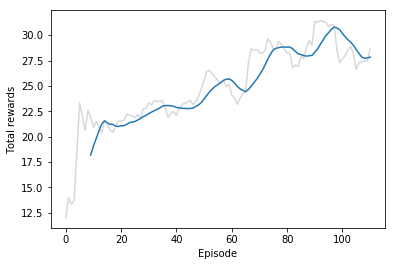

In [182]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Average losses')

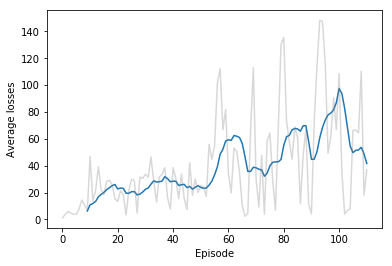

In [183]:
eps, arr = np.array(loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Average losses')

## Testing

Let's checkout how our trained agent plays the game.

In [184]:
import gym

# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model-seq.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    initial_state = sess.run(model.initial_state) # Qs or current batch or states[:-1]
    state = env.reset()
    total_reward = 0
    while True:
        env.render()
        action_logits, initial_state = sess.run([model.actions_logits, model.final_state],
                                                feed_dict = {model.states: state.reshape([1, -1]), 
                                                             model.initial_state: initial_state})
        action = np.argmax(action_logits)
        state, reward, done, _ = env.step(action)
        total_reward += reward
        if done:
            break
print('total_reward:{}'.format(total_reward))
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward:120.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.